# Exploration of Sentinel-3 dataset

The SLSTR visualization in EO Browser or Copernicus Browser shows Brightness Temperatures in Kelvin based on the reflectance values of the thermal infrared bands

In [106]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [107]:
!pip install sentinelhub

In [108]:
from sentinelhub import SHConfig

config = SHConfig()
config.instance_id = '8a46c75d-0e4c-40d2-b00e-e0590ef758ae'
#config.instance_id = 'cf027a43-b37f-4b11-8234-9349205cb14a'
config.sh_client_id = '7ff19b34-1148-42c7-8c77-ba50981048bc'
config.sh_client_secret =  'O4JUyx6UjNhOuWPkYhrF1YNndo4WoSWs'
config.sh_base_url = 'https://creodias.sentinel-hub.com/ogc/'



In [109]:

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest


In [110]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [111]:
# Exemple de BBOX sur le lac de la Gruyère :
coords_wgs84 = [7.02, 46.58, 7.15, 46.74]
coords_wgs84 = [5.526123,45.775186,10.689697,47.827908] #switzerland
resolution = 500

bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)

# extract the size based on bbx and the resolution
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {size} pixels')

Image shape at 500 m resolution: (793, 447) pixels


In [112]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["S3","S2","S1"],
            }],
            output: {
                bands: 3,
                sampleType: "AUTO"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.S3,sample.S2,sample.S1];
    }
"""

In [113]:
request_true_color = SentinelHubRequest(
    data_folder='gdrive/My Drive/test_dir',
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL3_SLSTR,  # Additional dataset (SLSTR)
            time_interval=('2020-05-01', '2020-05-31'),
            mosaicking_order='leastCC',
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config
)

In [114]:
true_color_imgs = request_true_color.get_data()

Image type: uint8, 255


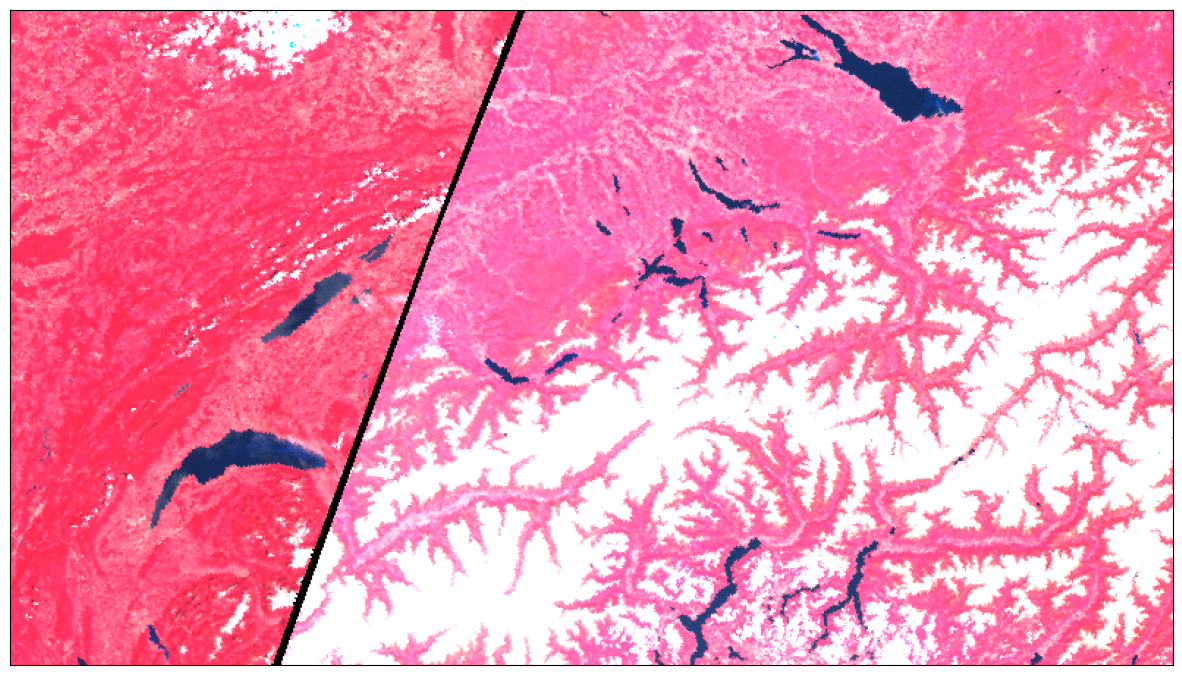

In [115]:
image = true_color_imgs[0]
print(f'Image type: {image.dtype}, {image.max()}')

# plot function
# factor 1/255 to scale between 0-1
# factor 6 to increase brightness
plot_image(image, factor=6/255, clip_range=(0,1))

In [116]:
evalscript_true_color = """
    // VERSION 3

    /**
      This script is directly based on the Landsat-8 Land Surface Temperature Mapping script by Mohor Gartner
      https://custom-scripts.sentinel-hub.com/landsat-8/land_surface_temperature_mapping/
      since the script uses Landsat TIRS B10 for brightness temperature
      mapping and Landsat OLI NDVI to scale for emissivity, this can be followed using
      Sentinel-3 SLSTR S08 and Sentinel-3 OLCI NDVI

      in order to use this script you have to enable "use additional datasets (advanced)"
      and set S-3 OLCI and S-3 SLSTR as the primary and additional dataset.

      Aliases should be
      - Sentinel-3 OLCI=S3OLCI
      - Sentinel-3 SLSTR=S3SLSTR

      STARTING OPTIONS
      for analysis of one image (EO Browser), choose option=0. In case of MULTI-TEMPORAL analyis,
      option values are following:
      0 - outputs average LST in selected timeline (% of cloud coverage should be low, e.g. < 10%)
      1 - outputs maximum LST in selected timeline (% of cloud coverage can be high)
      2 - THIS OPTION IS CURRENTLY NOT FUNCTIONAL - outputs standard deviation LST in selected timeline;
          minTemp and highTemp are overwritten with values 0 and 10 (% of cloud coverage should be low, e.g. < 5%)
    */
    var option = 1;

    // minimum and maximum values for output colour chart red to white for temperature in °C. Option 2 overwrites this selection!
    var minC = 0;
    var maxC = 50;


    ////INPUT DATA - FOR BETTER RESULTS, THE DATA SHOULD BE ADJUSTED
    // NVDIs for bare soil and NDVIv for full vegetation
    // Note: NVDIs for bare soil and NDVIv for full vegetation are needed to
    //       be evaluated for every scene. However in the custom script, default values are set regarding:
    // https://profhorn.meteor.wisc.edu/wxwise/satmet/lesson3/ndvi.html
    // https://www.researchgate.net/post/Can_anyone_help_me_to_define_a_range_of_NDVI_value_to_extract_bare_soil_pixels_for_Landsat_TM
    // NVDIs=0.2, NDVIv=0.8
    // other source suggests global values: NVDIs=0.2, NDVIv=0.5;
    // https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    var NDVIs = 0.2;
    var NDVIv = 0.8;

    // emissivity
    var waterE = 0.991;
    var soilE = 0.966;
    var vegetationE = 0.973;
    //var buildingE=0.962;
    var C = 0.009; //surface roughness, https://www.researchgate.net/publication/331047755_Land_Surface_Temperature_Retrieval_from_LANDSAT-8_Thermal_Infrared_Sensor_Data_and_Validation_with_Infrared_Thermometer_Camera

    //central/mean wavelength in meters, Sentinel-3 SLSTR B08 (almost the same as Landsat B10)
    var bCent = 0.000010854;

    // rho =h*c/sigma=PlanckC*velocityLight/BoltzmannC
    var rho = 0.01438; // m K

    //// visualization
    // if result should be std dev (option=2), overwrite minMaxC.
    if (option == 2) {
      minC = 0;
      maxC = 25;
    }
    let viz = ColorGradientVisualizer.createRedTemperature(minC, maxC);

    //this is where you set up the evalscript to access the bands of the two datasets in the fusion

    function setup() {
      return {
        input: [
          { datasource: "S3OLCI", bands: ["B06", "B08", "B17"] },
          { datasource: "S3SLSTR", bands: ["S8"] }],
        output: [
          { id: "default", bands: 3, sampleType: SampleType.AUTO }
        ],
        mosaicking: "ORBIT"
      }
    }


    //emissivity calc (Unchanged from Landsat script)
    //https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    //https://www.academia.edu/27239873/Investigating_Land_Surface_Temperature_Changes_Using_Landsat_Data_in_Konya_Turkey
    function LSEcalc(NDVI, Pv) {
      var LSE;
      if (NDVI < 0) {
        //water
        LSE = waterE;
      } else if (NDVI < NDVIs) {
        //soil
        LSE = soilE;
      } else if (NDVI > NDVIv) {
        //vegetation
        LSE = vegetationE;
      } else {
        //mixtures of vegetation and soil
        LSE = vegetationE * Pv + soilE * (1 - Pv) + C;
      }
      return LSE;
    }

    function evaluatePixel(samples) {
      // starting values max, avg, stdev, reduce N, N for multi-temporal
      var LSTmax = -999;
      var LSTavg = 0;
      var LSTstd = 0;
      var reduceNavg = 0;
      var N = samples.S3SLSTR.length;

      //to caputure all values of one pixel for for whole timeline in mosaic order
      var LSTarray = [];

      // multi-temporal: loop all samples in selected timeline
      for (let i = 0; i < N; i++) {
        //// for LST S8
        var Bi = samples.S3SLSTR[i].S8;
        var B06i = samples.S3OLCI[i].B06;
        var B08i = samples.S3OLCI[i].B08;
        var B17i = samples.S3OLCI[i].B17;

        // some images have errors, whole area is either B10<173K or B10>65000K. Also errors, where B06 and B17 =0. Therefore no processing if that happens, in addition for average and stdev calc, N has to be reduced!
        if ((Bi > 173 && Bi < 65000) && (B06i > 0 && B08i > 0 && B17i > 0)) {
          // ok image
          //1 Kelvin to C
          var S8BTi = Bi - 273.15;
          //2 NDVI - Normalized Difference vegetation Index - based on this custom script: https://custom-scripts.sentinel-hub.com/sentinel-3/ndvi/
          var NDVIi = (B17i - B08i) / (B17i + B08i);
          //3 PV - proportional vegetation
          var PVi = Math.pow(((NDVIi - NDVIs) / (NDVIv - NDVIs)), 2);
          //4 LSE land surface emmisivity
          var LSEi = LSEcalc(NDVIi, PVi);
          //5 LST
          var LSTi = (S8BTi / (1 + (((bCent * S8BTi) / rho) * Math.log(LSEi))));

          ////temporary calculation
          //avg
          LSTavg = LSTavg + LSTi;
          //max
          if (LSTi > LSTmax) { LSTmax = LSTi; }
          //array
          LSTarray.push(LSTi);
        } else {
          // image NOT ok
          ++reduceNavg;
        }
      }
      // correct N value if some images have errors and are not analysed
      N = N - reduceNavg;

      // calc final avg value
      LSTavg = LSTavg / N;

      // calc final stdev value
      for (let i = 0; i < LSTarray.length; i++) {
        LSTstd = LSTstd + (Math.pow(LSTarray[i] - LSTavg, 2));
      }
      LSTstd = (Math.pow(LSTstd / (LSTarray.length - 1), 0.5));

      // WHICH LST to output, it depends on option variable: 0 for one image analysis (OE Browser); MULTI-TEMPORAL: 0->avg; 1->max; 2->stdev
      let outLST = (option == 0)
        ? LSTavg
        : (option == 1)
          ? LSTmax
          : LSTstd;

      //// output to image
      return viz.process(outLST);
    }
"""

In [117]:
request_true_color = SentinelHubRequest(
    data_folder='gdrive/My Drive/test_dir',
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL3_OLCI,  # Revisa la colección de datos
            identifier='S3OLCI',
            time_interval=('2020-05-01', '2020-05-31'),
            mosaicking_order='mostRecent',
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL3_SLSTR,  # Additional dataset (SLSTR)
            identifier = 'S3SLSTR',
            time_interval=('2020-05-01', '2020-05-31'),
            mosaicking_order='leastCC',
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=size,
    config=config
)


In [118]:
true_color_imgs = request_true_color.get_data()

In [119]:
print(f'Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.')
print(f'Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}')

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (447, 793, 3)


Image type: uint8, 255


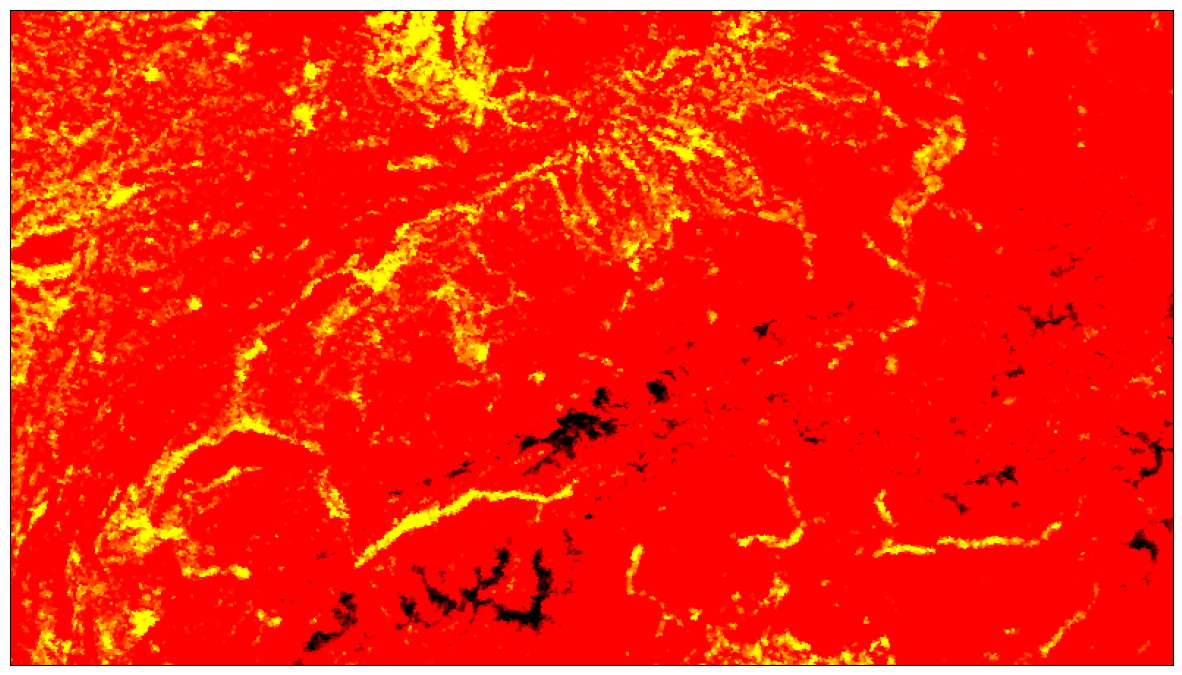

In [120]:
image = true_color_imgs[0]
print(f'Image type: {image.dtype}, {image.max()}')

# plot function
# factor 1/255 to scale between 0-1
# factor 6 to increase brightness
plot_image(image, factor=6/255, clip_range=(0,1))